**ATM Security & Efficiency improving System(ATM seis)**

Helmet detection ML model training part

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Attempt to change the current working directory

%cd /content/drive/MyDrive/helmet detector

/content/drive/MyDrive/helmet detector


In [ ]:
# Show list of folders

!ls

'Copy of detect_mask_image.py'	'Copy of train_mask_detector.py'   dataset   face_detector


[INFO] loading images...


[INFO] compiling model...
[INFO] training head...
Epoch 1/50
93/93 [==============================] - 28s 276ms/step - loss: 0.2181 - accuracy: 0.9653 - val_loss: 0.0110 - val_accuracy: 0.9957
Epoch 2/50
93/93 [==============================] - 23s 243ms/step - loss: 0.0414 - accuracy: 0.9930 - val_loss: 0.0081 - val_accuracy: 0.9979
Epoch 3/50
93/93 [==============================] - 22s 239ms/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 0.0073 - val_accuracy: 0.9979
Epoch 4/50
93/93 [==============================] - 28s 298ms/step - loss: 0.0245 - accuracy: 0.9951 - val_loss: 0.0062 - val_accuracy: 0.9979
Epoch 5/50
93/93 [==============================] - 24s 262ms/step - loss: 0.0263 - accuracy: 0.9957 - val_loss: 0.0051 - val_accuracy: 0.9979
Epoch 6/50
93/93 [==============================] - 23s 248ms/step - loss: 0.0281 - accuracy: 0.9957 - val_loss: 0.0059 - val_accuracy: 0.9979
Epoch 7/50
93/93 [==============================] - 23s 244ms/step - loss: 0.0233 - accuracy

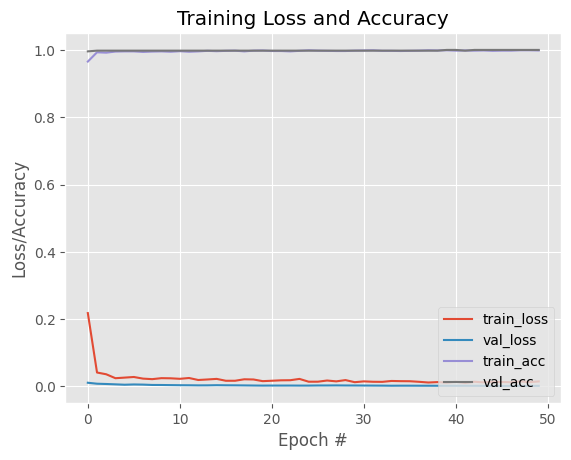

In [ ]:
# import module and libraries

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os



# # Initialization

INIT_LR = 1e-4                                                 # sets the initial rate for the optimizer
EPOCHS = 50                                                    # number of times the model will process the entire dataset during training
BS = 20																												 # number of images processed in a single step during training



# Loarding & Preprocessing images

print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/drive/MyDrive/helmet detector/dataset'))         # Lists image paths within the specified dataset directory
data = []
labels = []                                                         # Creates empty lists to store image data and corresponding label

for imagePath in imagePaths:                                        # iterating through image paths
	label = imagePath.split(os.path.sep)[-2]                          # extracts the label from image path
	image = load_img(imagePath, target_size=(224, 224))               # loads the image and resizing images
	image = img_to_array(image)                                       # converts the image to a NumPy array
	image = preprocess_input(image)                                   # applies necessary preprocessing


# Storing Data and Labels

	data.append(image)                                                # adds the preprocessed image array to the data list
	labels.append(label)                                              # adds the corresponding label to the labels list


# Converting to NumPy arrays

data = np.array(data, dtype="float32")                              # converts the data list into a NumPy array of 32-bit floating-point values
labels = np.array(labels)                                           # converts the labels list into a NumPy array


# Encoding Labels

lb = LabelBinarizer()                                               # creates a object to convert text labels into numerical representaions
labels = lb.fit_transform(labels)                                   # fits the label binarizer to the labels and transforms them into binary arrays
labels = to_categorical(labels)                                     # converts the binary arrays into a one-hot encoded format



# Splitting Data

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


# Image Augmentation

aug = ImageDataGenerator(                                        # Creating an ImageDataGenerator class from the Keras library( class is designed for real-time data augmentation during model training)
	rotation_range=20,                                             # Randomly rotates images by up to 20 degrees
	zoom_range=0.15,                                               # Randomly zooms images in or out by up to 15%
	width_shift_range=0.2,                                         # Randomly shifts images horizontally by up to 20% of their width
	height_shift_range=0.2,                                        # Randomly shifts images vertically by up to 20% of their height
	shear_range=0.15,                                              # Randomly applies shearing transformations to images, distorting their shape
	horizontal_flip=True,                                          # Randomly flips images horizontally
	fill_mode="nearest")                                           # Specifies how to fill in any missing pixels that might result from transformations,
	                                                               # in this case,using the nearest pixel values


# Model Architecture
# Loading the Base Model / loads a pre-trained MobileNetV2 model from Keras.

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


# Creating the Head Model

headModel = baseModel.output


# Adding layers to the Head Model

headModel = AveragePooling2D(pool_size=(7, 7))(headModel)           # Applies average pooling with a 7x7 pool size to reduce spatial dimensions
headModel = Flatten(name="flatten")(headModel)                      # Flattens the pooled features into a 1D vector for further processing.
headModel = Dense(128, activation="relu")(headModel)                # Adds a dense layer with 128 neurons and ReLU activation for non-linearity.
headModel = Dropout(0.5)(headModel)                                 # Applies dropout regularization with a rate of 0.5 to prevent overfitting
headModel = Dense(2, activation="softmax")(headModel)               # Adds a final dense layer with 2 neurons  and softmax activation for probability output


# Combining Base and Head Model

model = Model(inputs=baseModel.input, outputs=headModel)


# Freezing Base Model layers

for layer in baseModel.layers:                                     # terates through all layers in the base model (MobileNetV2)
	layer.trainable = False                                          # Sets each layer's trainable attribute to False


# Compiling the Model

print("[INFO] compiling model...")
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#opt = Adam(learning_rate=0.01, decay=0.1)

			# Creates an Adam optimizer with a learning rate of 0.01 and a decay rate of 0.1 to adjust learning rate during training.
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=0.1)

			# complies the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


# Training the Model

print("[INFO] training head...")
H = model.fit(                                           # Trains the model using the fit method
	aug.flow(trainX, trainY, batch_size=BS),               # Generates augmented images in batches for training
	steps_per_epoch=len(trainX) // BS,                     # Number of batches per epoch
	validation_data=(testX, testY),                        # Validation data for monitoring performance
	validation_steps=len(testX) // BS,                     # Number of validation batches
	epochs=EPOCHS)                                         # Number of training epochs


# Evaluating the Model

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)          # Generates predictions on the testing set

predIdxs = np.argmax(predIdxs, axis=1)                  # Converts predicted probabilities to class indices for evaluation

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))



# Visualizing Training Results

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")


In [ ]:
# save accuracy result image

plt.savefig('result.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# get model summary

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

[INFO] computing face detections...
1/1 [==============================] - 0s 22ms/step


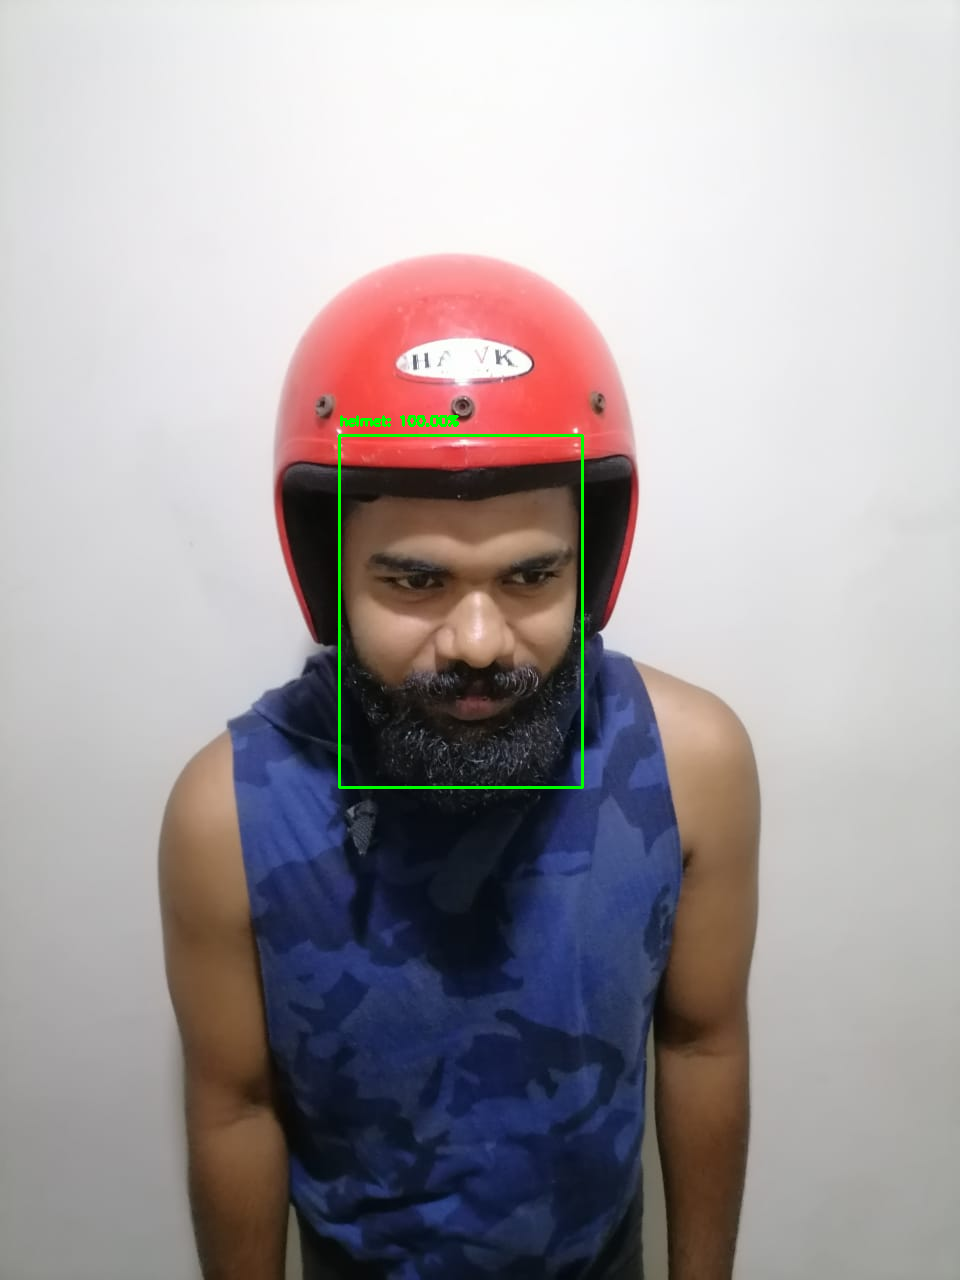

-1

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow


# import the image
image = cv2.imread('/content/drive/MyDrive/helmet detector/dataset/with_helmet/IMG-20231004-WA0226.jpg')

# create a copy of the image
orig = image.copy()

# get image dimensions
(h, w) = image.shape[:2]


#  Prepare image for face detection
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))


# Load the face detection model
net=cv2.dnn.readNet('/content/drive/MyDrive/face-mask-detector/face_detector/deploy.prototxt','/content/drive/MyDrive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel')


# Perform face detection
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()


# Iterate through detected faces
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])    # Extract bounding box coordinates for confident faces
		(startX, startY, endX, endY) = box.astype("int")

		(startX, startY) = (max(0, startX), max(0, startY))        # Ensure bounding box stays within image boundaries
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))


# Extract and preprocess the face region
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		(helmet, withouthelmet) = model.predict(face)[0]                   # Apply the helmet detection model

		label = "no_helmet" if helmet > withouthelmet else "helmet"        # Determine the label and color
		color = (0, 255, 0) if label == "helmet" else (0, 0, 255)

		label = "{}: {:.2f}%".format(label, max(helmet, withouthelmet) * 100)    # Format the label text

		cv2.putText(image, label, (startX, startY - 10),                         # Draw the bounding box and label
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

cv2_imshow(image)                                                            #  Display the image
cv2.waitKey(0)

In [ ]:
model.save('helmet_detection_final.h5')